# Prédiction des arrivées aux urgences

## Initialisation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statistics
import xgboost as xgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

KeyboardInterrupt: 

In [ ]:
type_target = 'arrivees_urgences'
assert type_target in ['hospitalisations', 'arrivees_urgences']
horizon = 15
NUM_FEATS = 50
DEPARTEMENT = 'Dijon'

In [ ]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18,8)

def teste(df, params, score=100000, ma=7, verbose=False):
    MAEs, MSEs = [], []
    new_score = 100000
    reg_best = None
    final = df.loc[df.index.year==2023]
    X_final = final.drop('target', axis=1)
    y_final = final['target']

    for max_depth in [3, 4, 5, 6, 7, 8, 9]:
        params['max_depth'] = max_depth
        train_val_test = df.copy()
        for annee in range(2019, 2024):
            train_val = train_val_test.loc[train_val_test.index.year != annee]
            test = train_val_test.loc[train_val_test.index.year == annee]
            X_test = test.drop('target', axis=1)
            y_test = test['target']
            X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                                  test_size=0.2, shuffle=False)
                    
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            dtest = xgb.DMatrix(X_test, label=y_test)
            evals = [(dtrain, 'train'), (dvalid, 'eval')]
            bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=verbose)
        
            y_pred = bst.predict(dtest)
            MAEs.append(mean_absolute_error(y_test, y_pred))
            MSEs.append(mean_squared_error(y_test, y_pred))

        current_score = statistics.mean(MSEs)
        if current_score < new_score:
            train_val_test = df.loc[df.index.year<2023]
            previous_score = new_score
            new_score = current_score
            if new_score < score:
                print(f"Amélioration avec {max_depth=}: {min(previous_score, score):.4f} -> {new_score:.4f}")
                new_score = statistics.mean(MSEs)
                X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                                    train_val_test['target'], 
                                                                    test_size=0.2, shuffle=False)

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dvalid = xgb.DMatrix(X_valid, label=y_valid)
                dtest = xgb.DMatrix(X_final, label=y_final)
                evals = [(dtrain, 'train'), (dvalid, 'eval')]
                bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                                early_stopping_rounds=15, verbose_eval=verbose)
                reg_best = bst
                y_pred = bst.predict(dtest)
                #y_pred_ma = pd.Series(y_pred).rolling(window=ma, center=True).mean()
                N = 365
                plt.figure()
                plt.plot(range(len(y_final))[-N:], y_final[-N:], label='actual', color='blue')
                plt.plot(range(len(y_pred))[-N:], y_pred[-N:], label='predict', color='orange')
                #plt.plot(range(len(y_pred))[-N:], y_pred_ma[-N:], label='trend', color='red')
                plt.legend()
                '''y_test_ma = y_final.rolling(window=ma, center=True).mean()
                
                plt.figure()
                plt.plot(range(len(y_final)), y_test_ma, label='actual')
                plt.plot(range(len(y_pred)), y_pred_ma, label='predict')
                plt.legend()
                '''
                display(plt.gcf())

                mean_y_test = np.mean(y_final)
                error_percentage = np.abs((y_pred - y_final) / mean_y_test) * 100
                percent_below_thresholds = {}
                for threshold in range(1, 12):  # de 1% à 30%
                    percent_below = np.mean(error_percentage < threshold) * 100
                    percent_below_thresholds[threshold] = percent_below
                for threshold, percent_below in percent_below_thresholds.items():
                    print(f"{percent_below:.2f}%,{threshold}%")

                print(f"   - MAE : {statistics.mean(MAEs):.2f} ({mean_absolute_error(y_pred, y_final):.2f} sur 2023)")
                print(f"   - MSE : {statistics.mean(MSEs):.2f} ({mean_squared_error(y_pred, y_final):.2f} sur 2023)")
    return new_score, reg_best

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/julienaudoux/Desktop/WORK(lab)/forecasting_models/.venv/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
# df = pd.read_feather('data_CHU Dijon.feather')
# df

In [ ]:
assert type_target in ['hospitalisations', 'arrivees_urgences']
if type_target == 'hospitalisations':
    df = pd.read_csv('RPU_vers_hospit_adultes.csv', sep=';')
    df['date_entree'] = pd.to_datetime(df['date_entree'], format="%d/%m/%Y")
    df.rename({'Total': type_target}, axis=1, inplace=True)
    df['target'] = df[type_target].copy()
    # on ajoute les arrivées aux urgences, que l'on suppose connues pour le jour J
    dff = pd.read_feather('CHU Dijon_volumes.feather')
    dff.rename({'Total': 'arrivees_urgences'}, axis=1, inplace=True)
    dff.reset_index(inplace=True)
    df = pd.merge(df, dff, on='date_entree')
else:
    df = pd.read_feather('CHU Dijon_volumes.feather')
    df.rename({'Total': type_target}, axis=1, inplace=True)
    df['target'] = df[type_target].copy()

In [ ]:
# On ajoute la target
if type_target == 'hospitalisations':
    horizon = 7
else:
    horizon = 3
df['mean'] = df[type_target].rolling(window=horizon, min_periods=1).mean()
df['target'] = df['mean'].shift(-2*horizon+1)
df.drop('mean', axis=1, inplace=True)

df.dropna(inplace=True)
df.shape

(2186, 4)

In [ ]:
for k in range(2*horizon-1, 15):
    df[f'target_history-{k}'] = df['target'].shift(k)

In [ ]:
for k in range(1, 15):
    df[f'{type_target}_history-{k}'] = df[type_target].shift(k)

In [ ]:
dg = pd.read_csv('features_all_origin.csv', sep=',')
dg.drop('Total', axis=1, inplace=True)
dg['date_entree'] = pd.to_datetime(dg['date_entree'], format="%Y-%m-%d")
df = pd.merge(df, dg, on='date_entree', how='left')
df.set_index('date_entree', inplace=True)
df.dropna(inplace=True)

In [ ]:
print(f"Moyenne : {df['target'].mean():.2f}, Ecart-type : {df['target'].std():.2f}")
print(f"Baseline : {mean_absolute_error(df['target'], [df['target'].mean()]*len(df)):.2f}")

Moyenne : 182.61, Ecart-type : 30.18
Baseline : 21.46


In [ ]:
df['HNFC_moving'] = df['HNFC_moving']=='Après'
df.drop('nom_etablissement_x', axis=1, inplace=True)
df.drop('nom_etablissement_y', axis=1, inplace=True)
df = df.drop(df.loc['2020-03':'2020-05'].index)

In [ ]:
shifted = df["target"].shift(2*horizon-1)
for ma in [2, 3, 7, 15, 30]:    
    window = shifted.rolling(window=ma)
    df[f'target_ma_{ma}'] = window.mean()
    df.bfill(inplace=True)

shifted = df[type_target].shift(1)
for ma in [2, 3, 7, 15, 30]:    
    window = shifted.rolling(window=ma)
    df[f'{type_target}_ma_{ma}'] = window.mean()
    df.bfill(inplace=True)


In [ ]:
# On sauvegarde notre dataframe
df0 = df.copy()

## On va commencer par prédire la tendance

### Calendaire

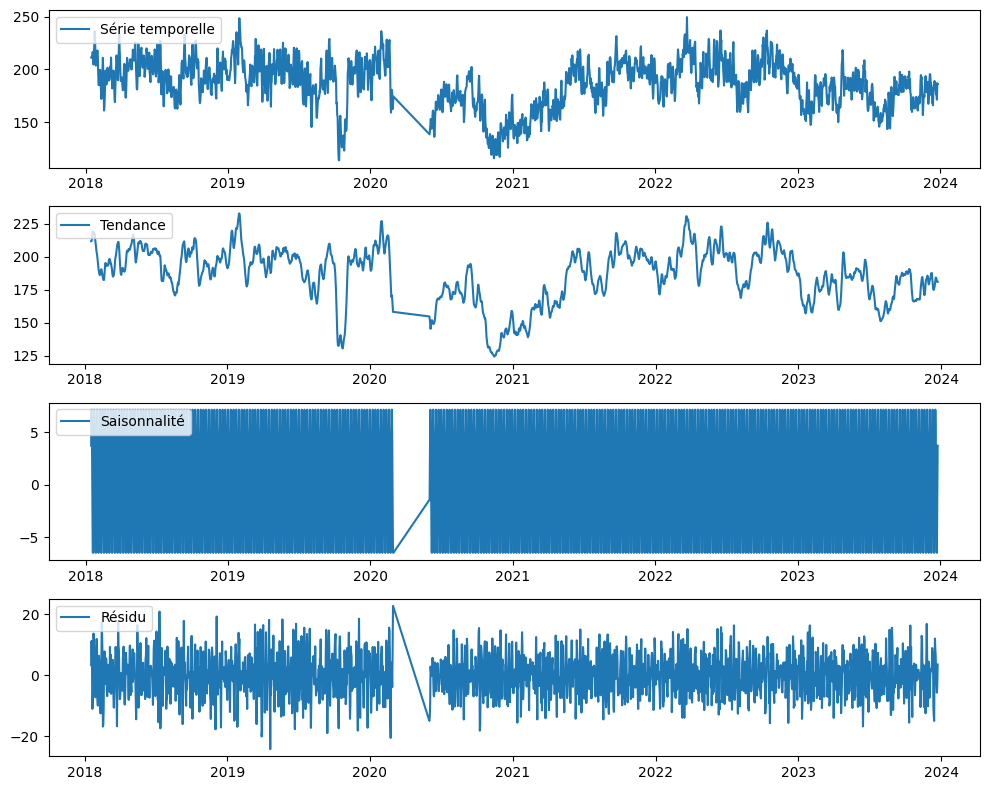

In [ ]:
y = df['target']
result = seasonal_decompose(y, model='additive', period=7)

# Affichage des composantes
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(y, label='Série temporelle')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Tendance')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Saisonnalité')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Résidu')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
df = df0.copy()
df['target'] = result.trend.copy()
df.dropna(inplace=True)

Amélioration avec max_depth=3: 100000.0000 -> 613.6008


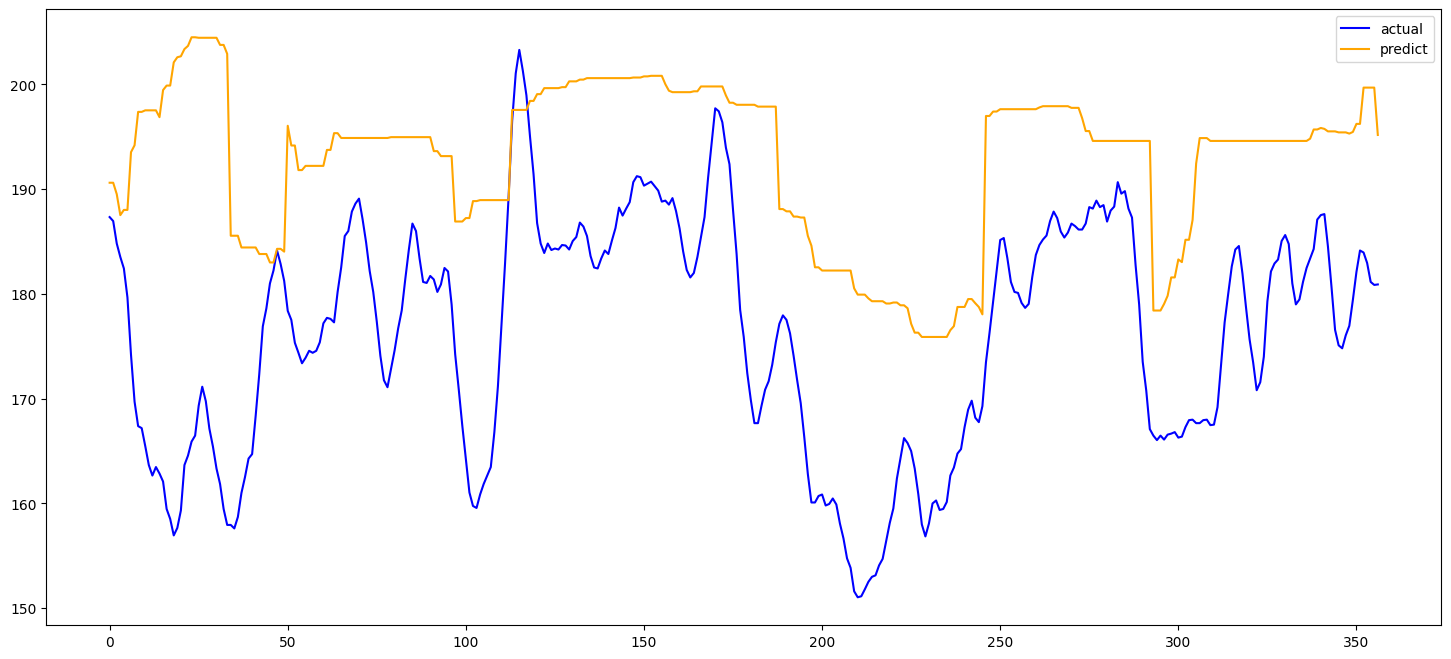

1.68%,1%
3.92%,2%
6.44%,3%
11.20%,4%
14.29%,5%
21.01%,6%
32.49%,7%
42.58%,8%
53.50%,9%
62.18%,10%
70.59%,11%
   - MAE : 18.11 (16.85 sur 2023)
   - MSE : 613.60 (361.89 sur 2023)
Amélioration avec max_depth=4: 613.6008 -> 612.1946


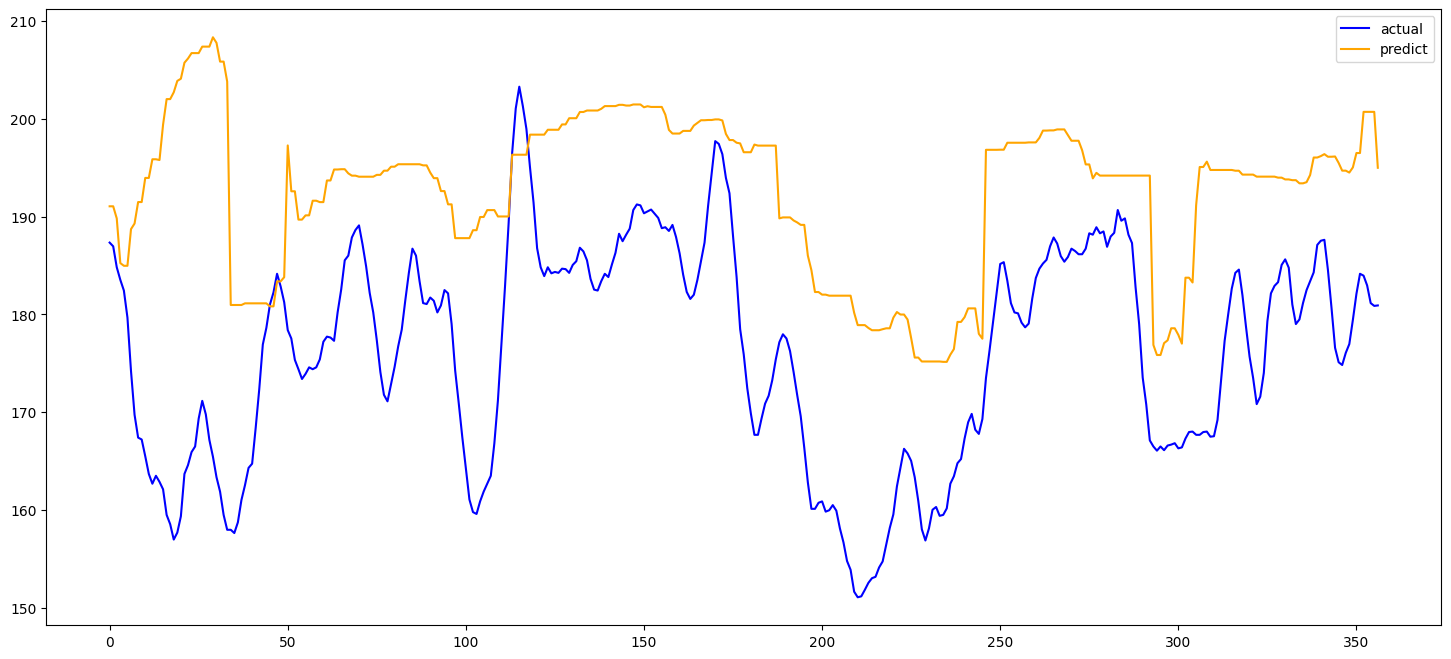

1.96%,1%
4.20%,2%
7.28%,3%
11.76%,4%
15.13%,5%
20.73%,6%
33.05%,7%
44.54%,8%
56.58%,9%
65.83%,10%
70.59%,11%
   - MAE : 18.07 (16.58 sur 2023)
   - MSE : 612.19 (356.62 sur 2023)


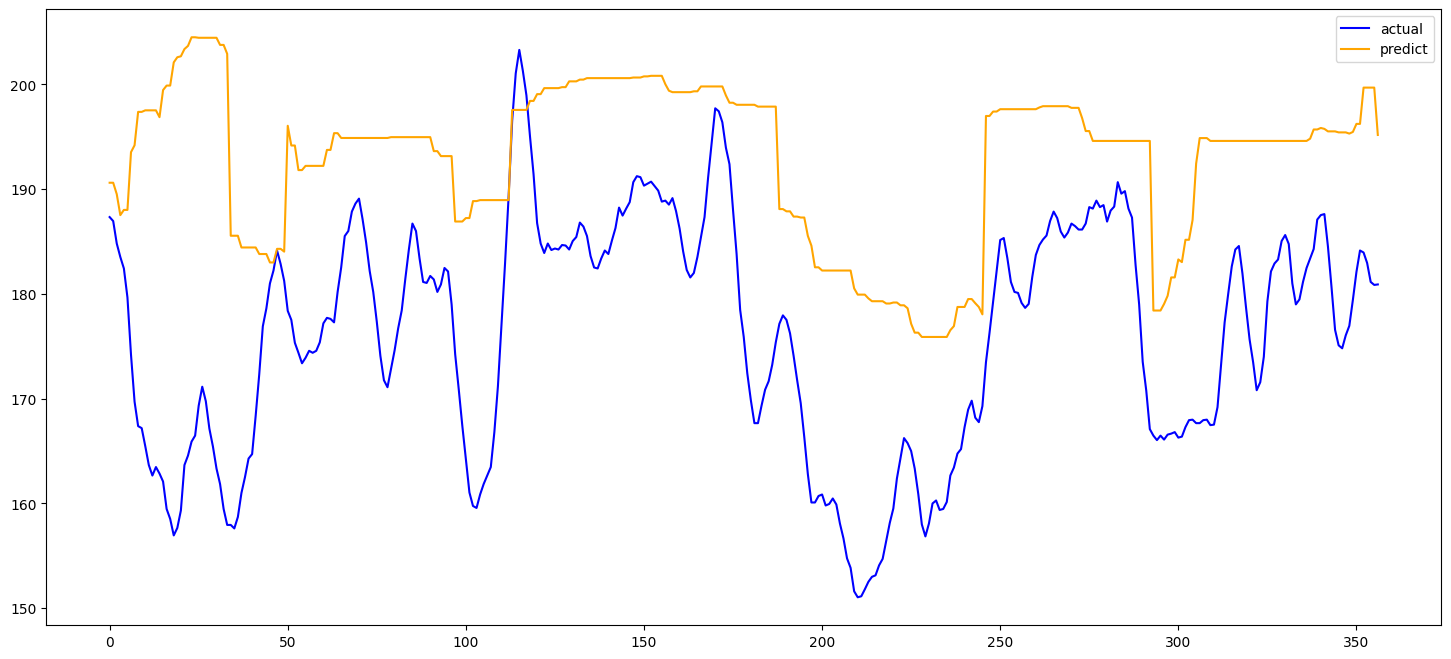

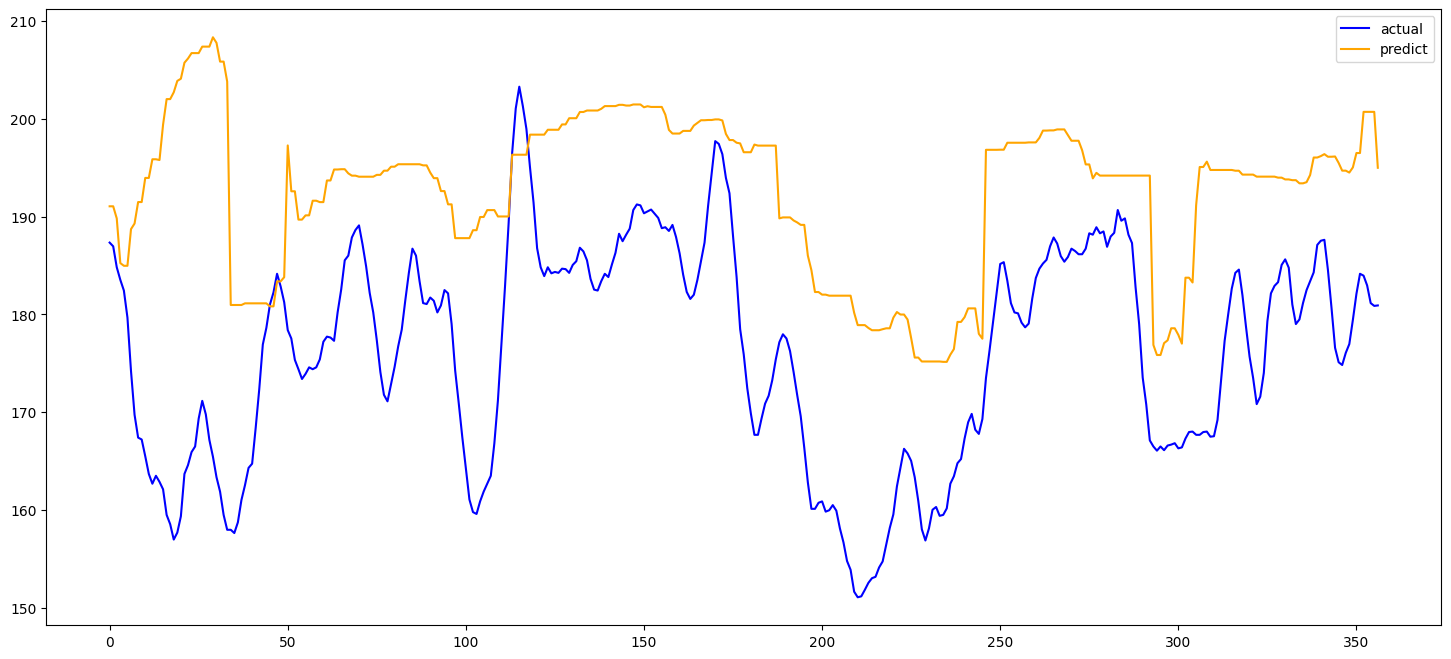

In [ ]:
params = {'eta': 0.05, 
          'objective': 'reg:absoluteerror', 
          'eval_metric': ['rmse', 'mae'],
          'subsample': 0.7, 
          'colsample_bytree': 1,
          'nthread': -1}

score = 100000
cols = ['dayofYear', 'month']
col = "holidays"
new_score, _ = teste(df[cols+[col, 'target']], params, score=score)

### Historique

In [ ]:
params = {'eta': 0.05, 
		  'objective': 'reg:squarederror',
          'eval_metric': ['rmse', 'mae'], 
          # seule la rmse sera utilisée pour valider
          'subsample': 0.7, 'colsample_bytree': 0.7,
          'nthread': -1}

Amélioration avec max_depth=3: 100000.0000 -> 322.1409


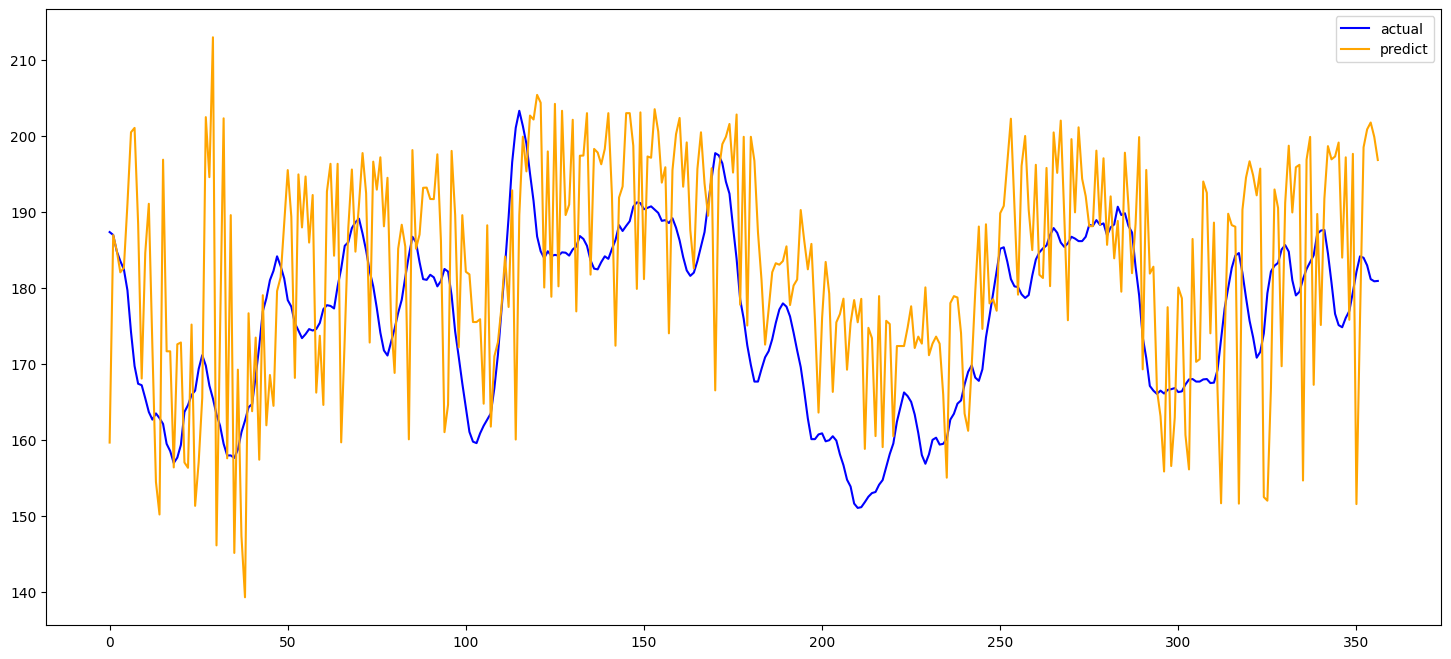

9.52%,1%
15.13%,2%
22.69%,3%
31.93%,4%
38.94%,5%
46.50%,6%
53.78%,7%
61.34%,8%
70.31%,9%
76.75%,10%
81.51%,11%
   - MAE : 13.90 (12.15 sur 2023)
   - MSE : 322.14 (215.20 sur 2023)
MAE: 14.48


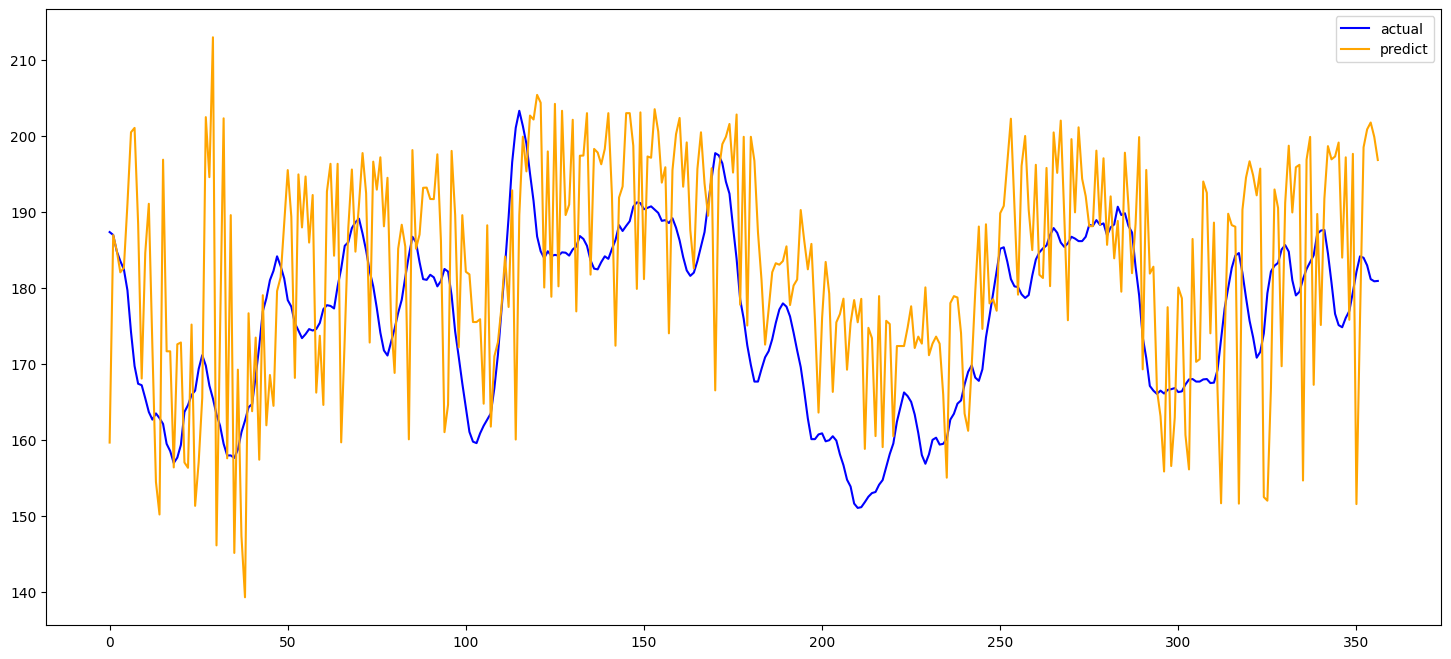

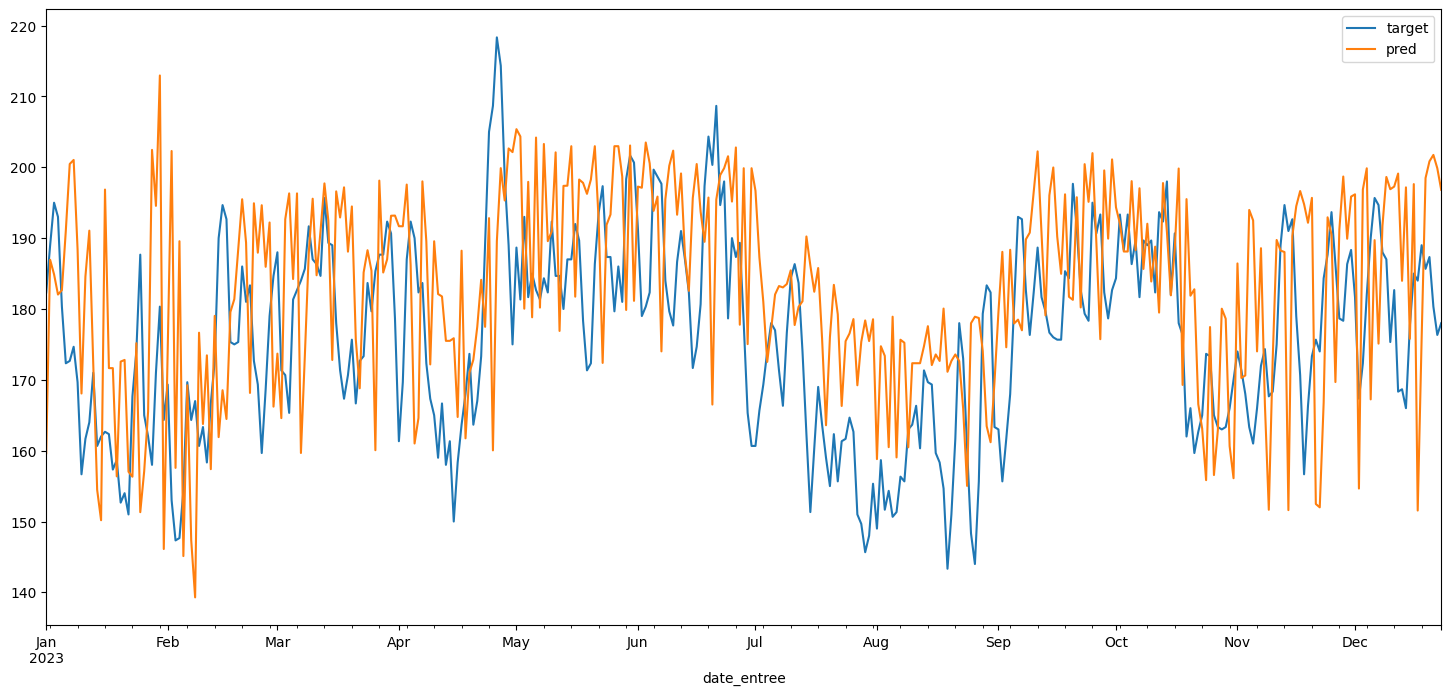

In [ ]:
cols = ['dayofYear', 'month', 'holidays', 'arrivees_urgences']
score, reg = teste(df[cols+['target']], params)

dg = df0.loc[df0.index.year == 2023][:-3]
dg['pred'] = reg.predict(xgb.DMatrix(df.loc[df.index.year == 2023][cols]))
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


Amélioration avec max_depth=3: 100000.0000 -> 277.4230


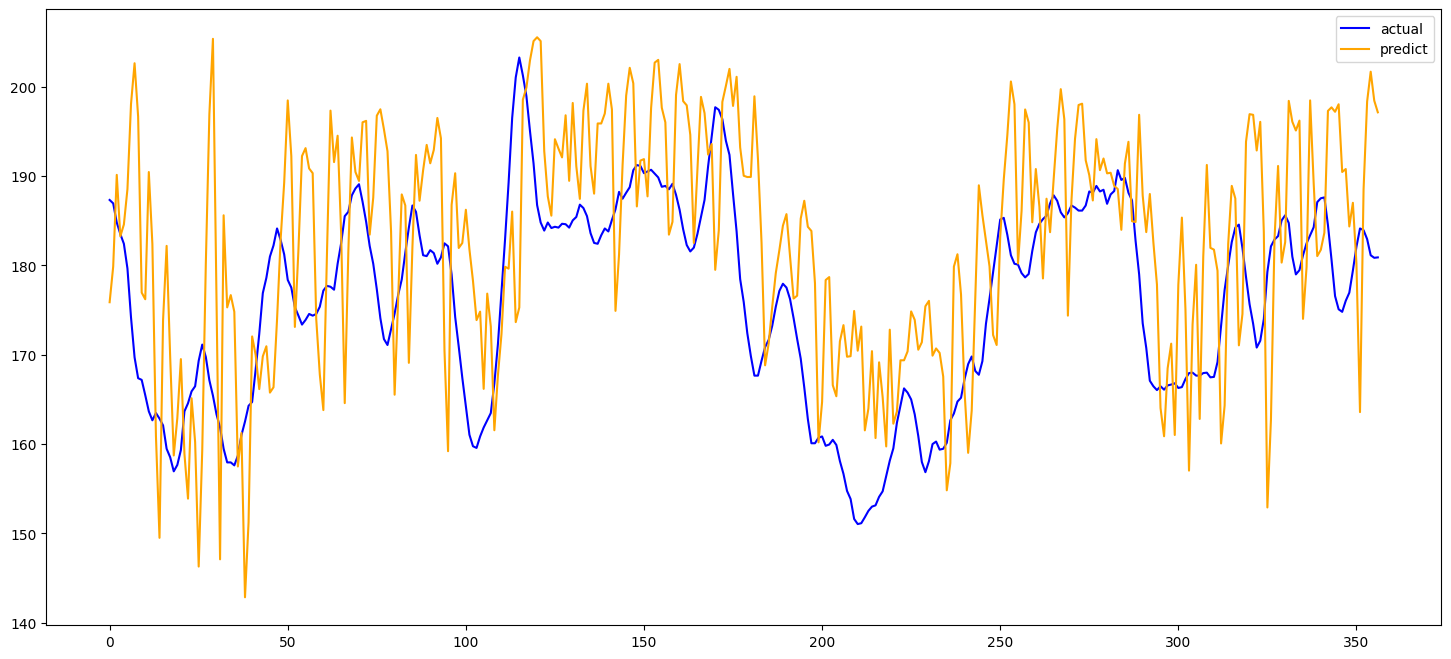

8.12%,1%
19.05%,2%
28.01%,3%
35.29%,4%
42.86%,5%
51.54%,6%
59.66%,7%
68.35%,8%
75.91%,9%
82.63%,10%
86.83%,11%
   - MAE : 12.44 (10.76 sur 2023)
   - MSE : 277.42 (166.96 sur 2023)
MAE: 12.93


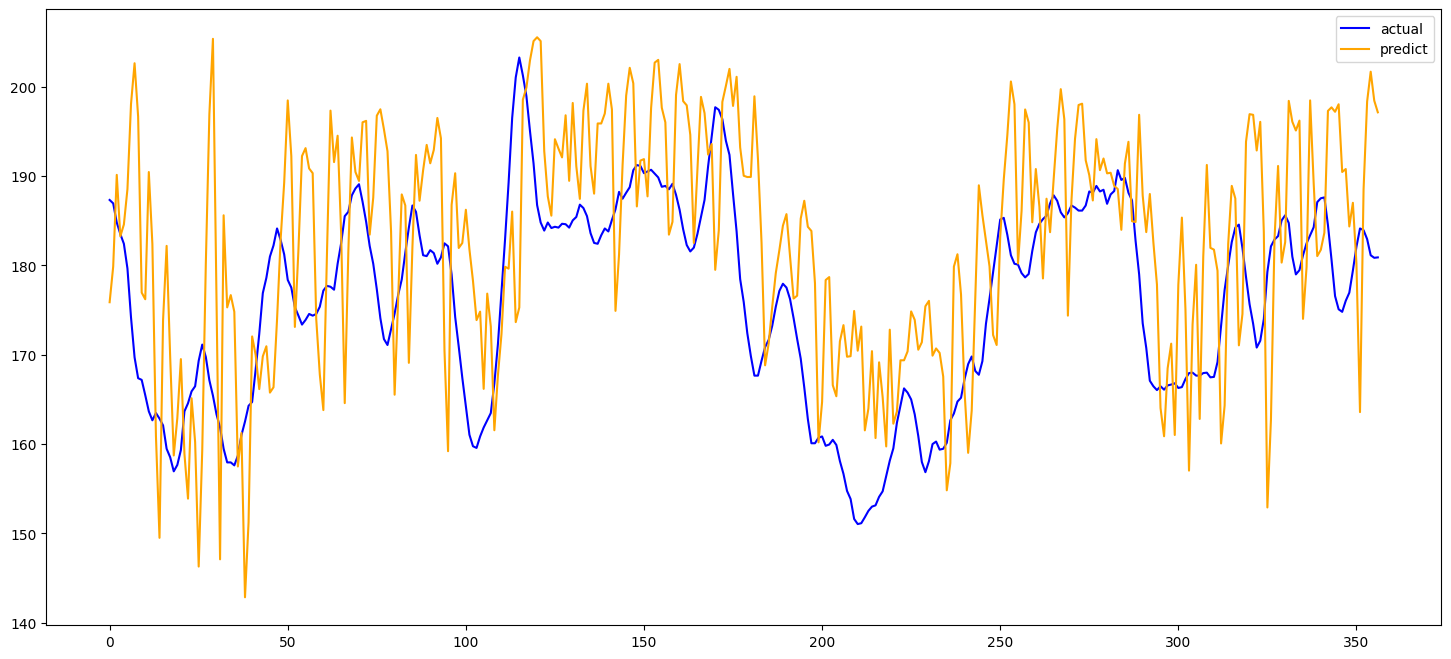

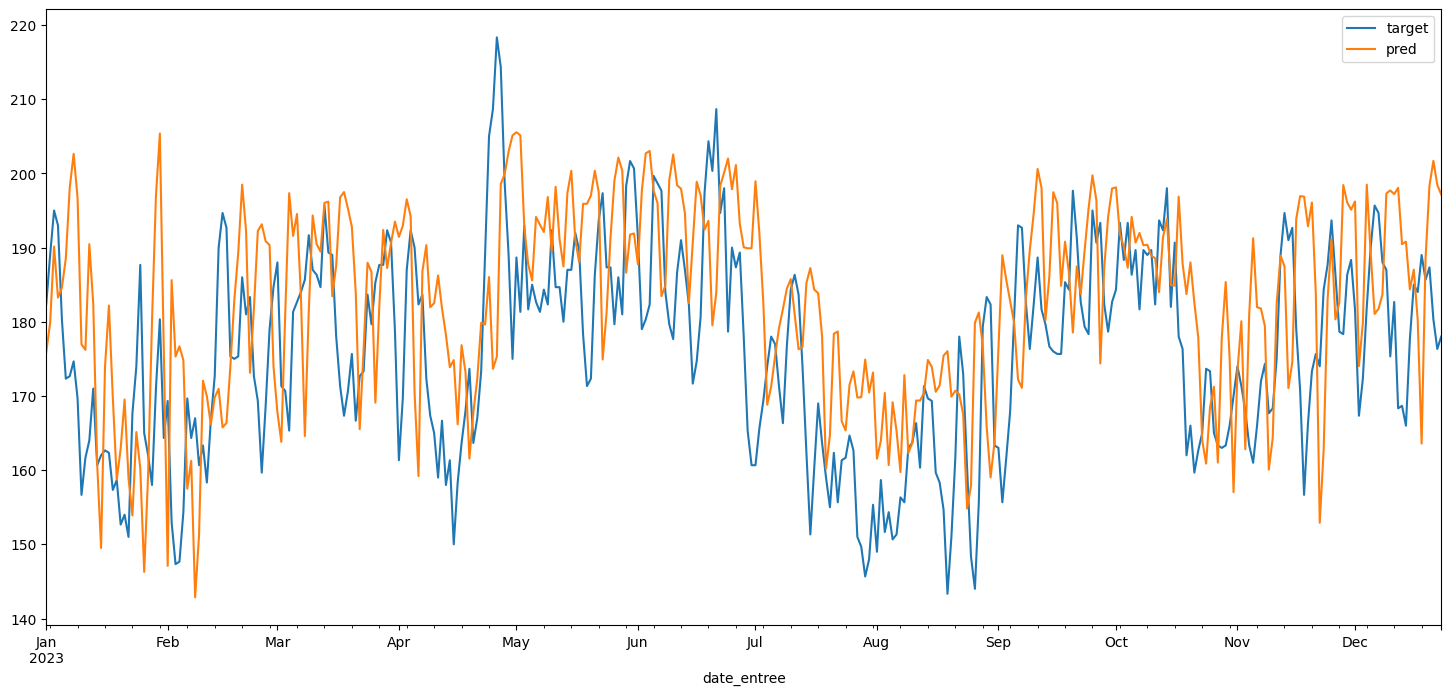

In [ ]:
cols = ['dayofYear', 'month', 'holidays', 'arrivees_urgences', 'arrivees_urgences_history-1']
score, reg = teste(df[cols+['target']], params)

dg = df0.loc[df0.index.year == 2023][:-3]
dg['pred'] = reg.predict(xgb.DMatrix(df.loc[df.index.year == 2023][cols]))
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


MAE: 11.76


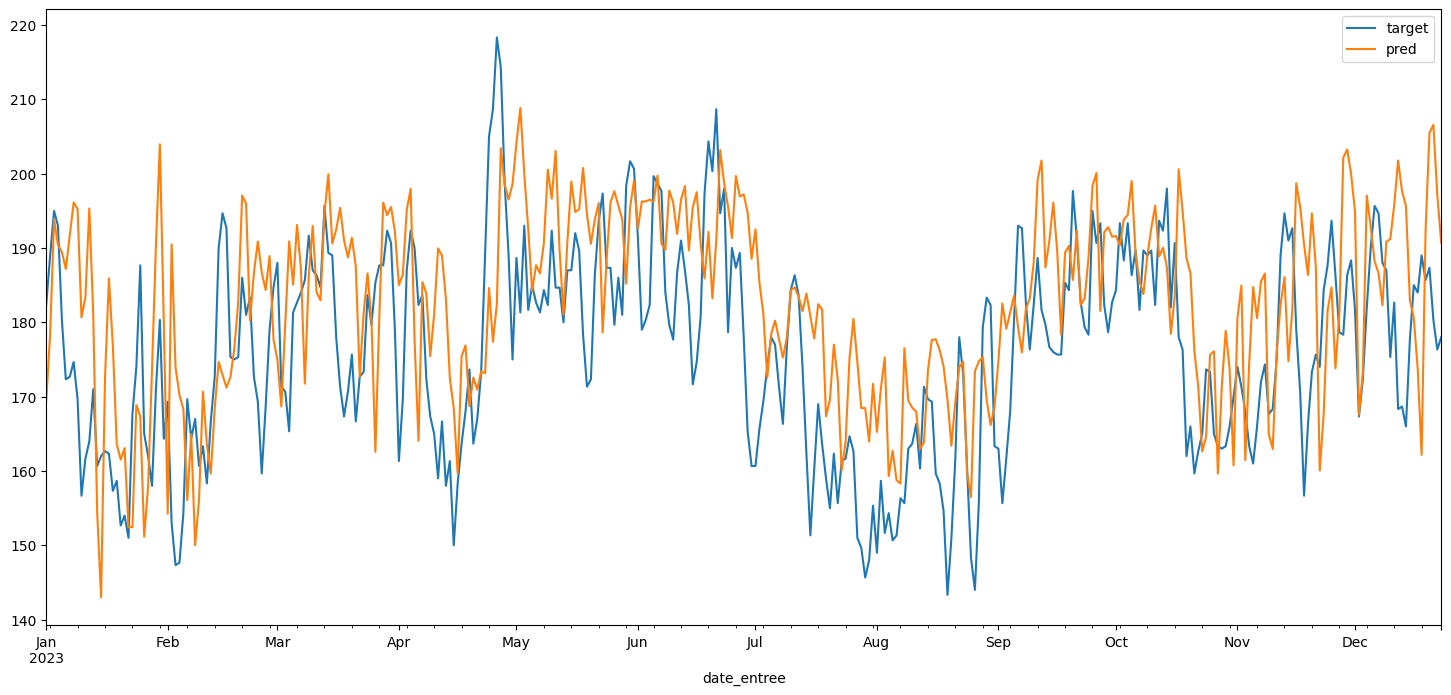

In [ ]:
dg['seasonal'] = result.seasonal
dg['pred'] = dg.apply(lambda x: x['pred'] + x['seasonal'], axis=1)
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


In [ ]:
dg0 = df0.copy()
dg0['resid'] = result.resid
dg0.drop('target', axis=1, inplace=True)
dg0.rename({'resid': 'target'}, axis=1, inplace=True)
dg0.dropna(inplace=True)
dg0['target'] = dg0['target'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Paramètres adaptés pour la classification binaire
params = {
    'eta': 0.05, 
    'objective': 'binary:logistic',  # Classification binaire
    'eval_metric': ['logloss', 'error'],  # Log loss et taux d'erreur
    'subsample': 0.7, 
    'colsample_bytree': 0.7,
    'nthread': -1
}

X_final = dg0.loc[dg0.index.year == 2023].drop('target', axis=1)
y_final = dg0.loc[dg0.index.year == 2023]['target']

train_val_test = dg0.loc[dg0.index.year < 2023]
X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                    train_val_test['target'], 
                                                    test_size=0.2, shuffle=False)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_final, label=y_final)
evals = [(dtrain, 'train'), (dvalid, 'eval')]


# Entraînement avec early stopping
bst = xgb.train(
    params,
    dtrain,  # DMatrix contenant les données d'entraînement
    num_boost_round=100000,
    evals=evals,  # Liste des ensembles d'évaluation
    early_stopping_rounds=15,
    verbose_eval=True
)

# Prédiction des probabilités sur un ensemble de test
proba_preds = bst.predict(dtest)

# Conversion des probabilités en classes binaires (0 ou 1)
class_preds = (proba_preds >= 0.5).astype(int)

scale = result.resid.dropna().abs().mean()

class_preds = [(2*p-1)*scale for p in class_preds]

# Affichage des prédictions de classes
print(class_preds)

[0]	train-logloss:0.67900	train-error:0.26948	eval-logloss:0.69245	eval-error:0.46802
[1]	train-logloss:0.67024	train-error:0.24836	eval-logloss:0.69165	eval-error:0.45640
[2]	train-logloss:0.65721	train-error:0.19374	eval-logloss:0.69015	eval-error:0.45930
[3]	train-logloss:0.64867	train-error:0.19519	eval-logloss:0.69015	eval-error:0.47965
[4]	train-logloss:0.63797	train-error:0.17189	eval-logloss:0.68772	eval-error:0.47384
[5]	train-logloss:0.62578	train-error:0.14639	eval-logloss:0.68474	eval-error:0.42733
[6]	train-logloss:0.61721	train-error:0.14130	eval-logloss:0.68525	eval-error:0.42151
[7]	train-logloss:0.60736	train-error:0.13037	eval-logloss:0.68594	eval-error:0.45058
[8]	train-logloss:0.59830	train-error:0.11945	eval-logloss:0.68708	eval-error:0.44767
[9]	train-logloss:0.58845	train-error:0.11071	eval-logloss:0.68389	eval-error:0.44767
[10]	train-logloss:0.57890	train-error:0.09687	eval-logloss:0.68440	eval-error:0.43314
[11]	train-logloss:0.56828	train-error:0.08813	eval-l

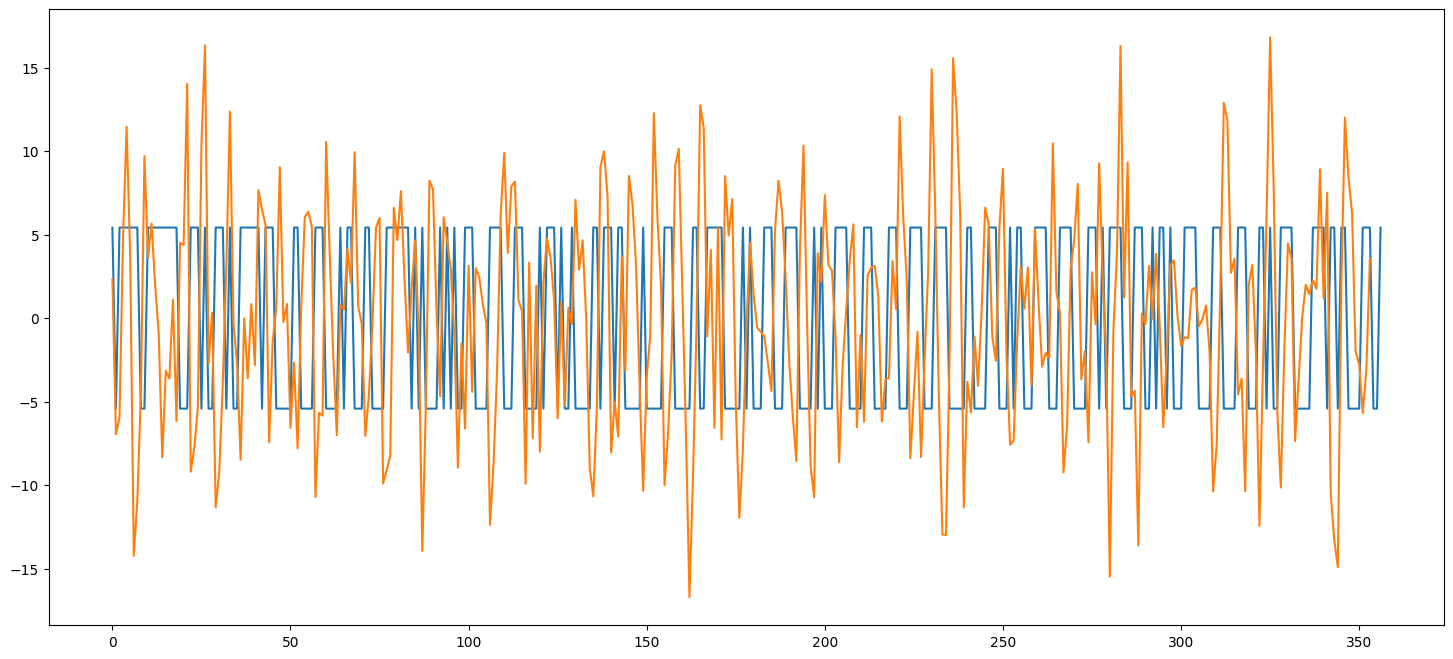

In [ ]:
plt.plot(range(len(class_preds)), class_preds)
plt.plot(range(len(class_preds)), result.resid[-len(class_preds):])
plt.show()

MAE: 11.60


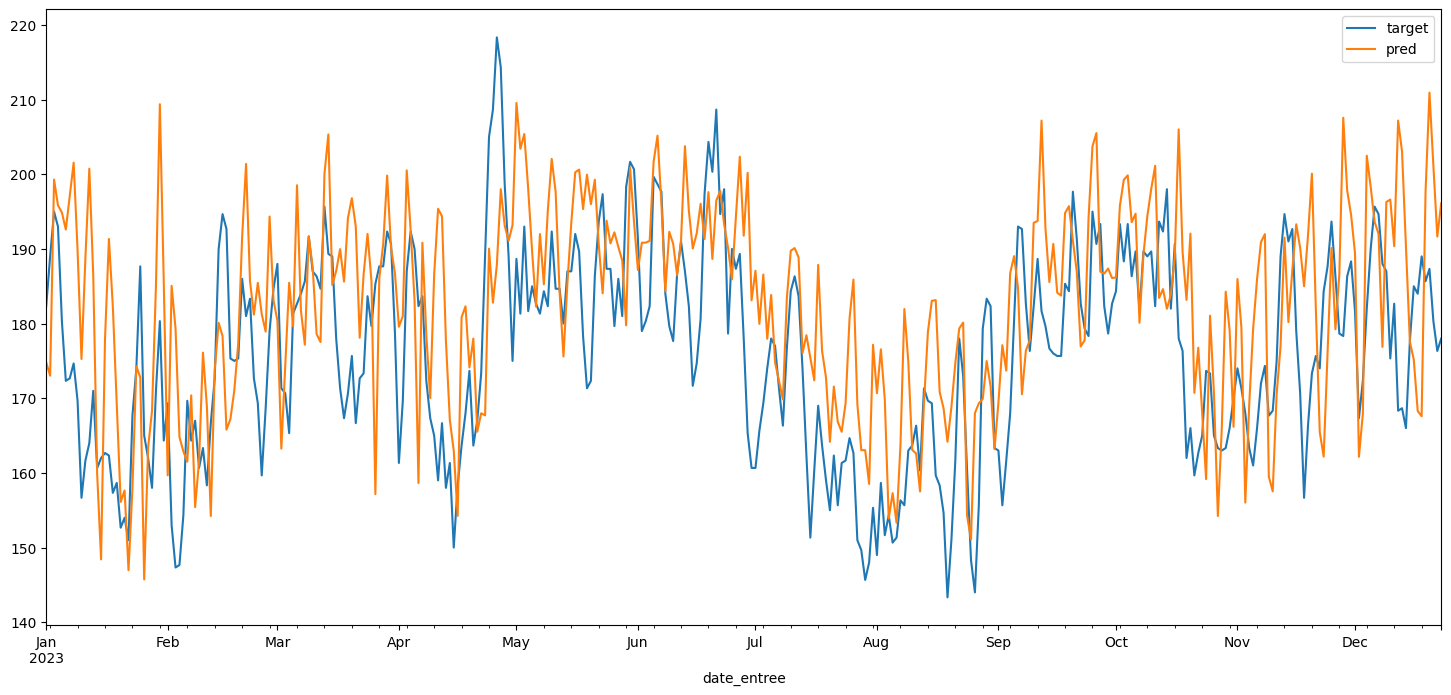

In [ ]:
dg['residue'] = class_preds
dg['pred'] = dg.apply(lambda x: x['pred'] + x['residue'], axis=1)
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


In [ ]:
# Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
importance_gain = bst.get_score(importance_type='gain')
importance_cover = bst.get_score(importance_type='cover')
importance_weight = bst.get_score(importance_type='weight')

df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df['gain_norm'] = df['gain'] / df['gain'].sum()
df['cover_norm'] = df['cover'] / df['cover'].sum()
df['weight_norm'] = df['weight'] / df['weight'].sum()

w_gain = 0.5
w_cover = 0.3
w_weight = 0.2

df['importance'] = (df['gain_norm'] * w_gain) + (df['cover_norm'] * w_cover) + (df['weight_norm'] * w_weight)

df.sort_values(by='importance', ascending=False, inplace=True)
df['rank'] = df['importance'].rank(ascending=False)

df.reset_index(inplace=True)
df.rename(columns={'index': 'feature'}, inplace=True)
print(df[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']])


                          feature       gain       cover  weight  importance  \
0                       dayofweek  15.527477  205.904205    11.0    0.011211   
1      meteo_CHU DIJON_0_tmin_J-6  10.161547  238.496780     1.0    0.008750   
2    arrivees_urgences_history-14  11.728303  199.869598     1.0    0.008101   
3               trend_hopital_J-5   9.640372   88.970299    17.0    0.008068   
4          arrivees_urgences_ma_2   7.734809  215.379776     1.0    0.007593   
..                            ...        ...         ...     ...         ...   
338               total_CHU Dijon   0.760000    3.326962     1.0    0.000469   
339           total_CHU Dijon_J-7   0.658912    2.368267     1.0    0.000421   
340            inc_varicelle_J-17   0.592687    2.791381     1.0    0.000417   
341    meteo_CHU DIJON_0_tmin_J-3   0.355941    2.406464     1.0    0.000353   
342             inc_diarrhee_J-18   0.310610    2.486791     1.0    0.000344   

      rank  
0      1.0  
1      2.0  
